In [24]:
import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import tifffile
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.optimize import minimize, LinearConstraint, Bounds, differential_evolution, basinhopping, shgo, dual_annealing, direct




def get_midline(arr):
    mid_x = arr.shape[1]//2
    return arr[mid_x]

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

In [25]:
def get_real_PSF(PSF_size_xyz):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    
    real_PSF = real_PSF[
        :, # 23 Z stacks total
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    real_PSF = real_PSF[peak_intensity_z]
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.max()
    return real_PSF

In [26]:
def get_real_PSF(PSF_size_xyz):
    pix_mic_conv = 0.05
    real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
    real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv) , anti_aliasing=True)
    #real_PSF = gaussian(real_PSF, sigma = 0.75)
    midpoint_xy = real_PSF.shape[1]//2
    
    original_z = real_PSF.shape[0]
    original_xy = real_PSF.shape[1]
    
    max_intensities = real_PSF.max(axis=(1,2))
    peak_intensity_z =  np.argwhere(max_intensities == np.max(max_intensities))[0][0]
    
    

    
    real_PSF = real_PSF[peak_intensity_z]
    real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
    real_PSF = np.clip(real_PSF, 0, np.inf)
    real_PSF = real_PSF / real_PSF.max()


    real_PSF = real_PSF[
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1,
        midpoint_xy - PSF_size_xyz//2:midpoint_xy + PSF_size_xyz//2+1
    ]
    
    return real_PSF

In [27]:
real_PSF = get_real_PSF(41)

In [28]:
real_PSF.shape

(41, 41)

In [29]:
PSF_depth = 1
def PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset):
    synthetic = psfm.make_psf(
        [0],
        nx = 41,
        dxy = 0.065/1.5,
        pz = pz,
        ti0 = ti0,
        ni0 = ni0,
        ni = ni, 
        tg0 = tg0,
        ng0 = ng0,
        ng = ng,
        ns = ns,
        wvl = 0.515,
        NA = NA,
        model = "vectorial"
        ) + offset
    #synthetic -= synthetic.min()
    synthetic = synthetic / synthetic.max()
    return synthetic

def error_function(params):
    pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset = params
    #if (NA > ni) or (NA > ni0) or (pz < 0):
    #    return 1000
    synthetic = PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset)[0]
    return np.nansum((real_PSF - synthetic) ** 2)

def error_function(params):
    pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset = params
    #if (NA > ni) or (NA > ni0) or (pz < 0):
    #    return 1000
    synthetic = PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset)[0]
    return np.nansum((np.log(real_PSF+np.finfo(np.float16).eps) - np.log(synthetic+np.finfo(np.float16).eps)) ** 2)

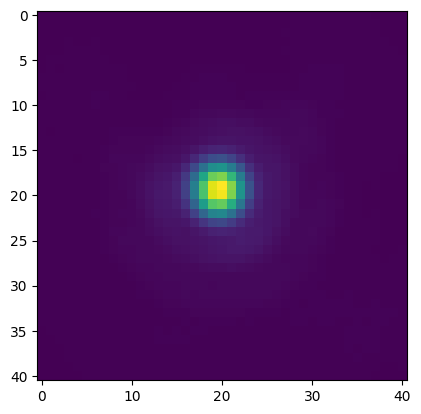

In [30]:
plt.imshow(real_PSF)

nx (int):       XY size of output PSF in pixels, must be odd.
dxy (float):    pixel size in sample space (microns) [default: 0.05]
pz (float):     depth of point source relative to coverslip (in microns) [default: 0]
ti0 (float):    working distance of the objective (microns) [default: 150.0]
ni0 (float):    immersion medium refractive index, design value [default: 1.515]
ni (float):     immersion medium refractive index, experimental value [default: 1.515]
tg0 (float):    coverslip thickness, design value (microns) [default: 170.0]
tg (float):     coverslip thickness, experimental value (microns) [default: 170.0]
ng0 (float):    coverslip refractive index, design value [default: 1.515]
ng (float):     coverslip refractive index, experimental value [default: 1.515]
ns (float):     sample refractive index [default: 1.47]
wvl (float):    emission wavelength (microns) [default: 0.6]
NA (float):     numerical aperture [default: 1.4]


In [31]:
params = [0, 140, 1.518, 1.518, 170, 170, 1.515, 1.515, 1.47, 1.49, 0]
pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset = params

In [32]:
bounds = Bounds([0, 100, 1.49, 1.49, 100, 100, 1.5, 1.5, 1.3, 1.3, 0], [5, 200, 1.6, 1.6, 200, 200, 2, 2, 2, 1.4899, 0])

In [33]:
def check_zero_cost(intermediate_result):
    if intermediate_result.fun == 0:
        print(f"Cost is zero for parameters: {intermediate_result.x}")
    return False  # return True if you want to stop the optimization here


In [34]:
%%time 
result = differential_evolution(error_function, bounds, workers = 23, disp = True, callback = check_zero_cost)

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 427.92880414503475
differential_evolution step 2: f(x)= 427.92880414503475
differential_evolution step 3: f(x)= 427.92880414503475
differential_evolution step 4: f(x)= 220.35442530743126
differential_evolution step 5: f(x)= 206.18338466649413
differential_evolution step 6: f(x)= 206.18338466649413
differential_evolution step 7: f(x)= 206.18338466649413
differential_evolution step 8: f(x)= 206.18338466649413
differential_evolution step 9: f(x)= 206.18338466649413
differential_evolution step 10: f(x)= 206.18338466649413
differential_evolution step 11: f(x)= 206.18338466649413
differential_evolution step 12: f(x)= 206.18338466649413
differential_evolution step 13: f(x)= 206.18338466649413
differential_evolution step 14: f(x)= 194.3783925342679
differential_evolution step 15: f(x)= 194.3783925342679
differential_evolution step 16: f(x)= 194.3783925342679
differential_evolution step 17: f(x)= 194.3783925342679
differential_evolution step 18: f(x)= 194.37

In [35]:
result

             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 144.83984999785096
                   x: [ 1.497e-02  1.025e+02  1.538e+00  1.512e+00
                        1.166e+02  1.537e+02  1.674e+00  1.639e+00
                        1.450e+00  1.463e+00  0.000e+00]
                 nit: 1000
                nfev: 150216
          population: [[ 2.195e-02  1.025e+02 ...  1.463e+00  0.000e+00]
                       [ 2.342e-02  1.097e+02 ...  1.455e+00  0.000e+00]
                       ...
                       [ 9.658e-03  1.885e+02 ...  1.453e+00  0.000e+00]
                       [ 4.865e-02  1.057e+02 ...  1.429e+00  0.000e+00]]
 population_energies: [ 1.448e+02  1.546e+02 ...  1.625e+02  1.647e+02]
                 jac: [-5.849e-03  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00  0.000e+00        nan]

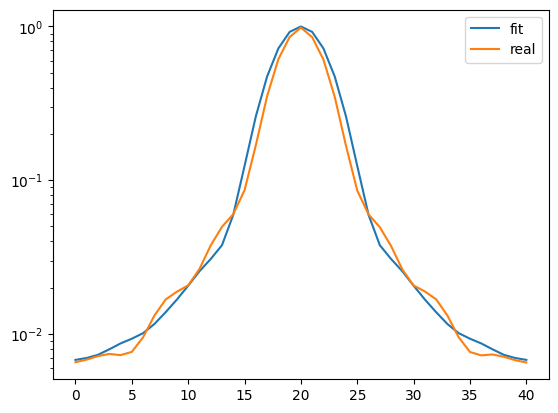

In [36]:
fitted_PSF = PSF_function(*result.x)
plt.plot(get_midline(fitted_PSF[0]), label ="fit")
plt.plot(get_midline_rotate_method(real_PSF), label = "real")
plt.yscale("log")
plt.legend()

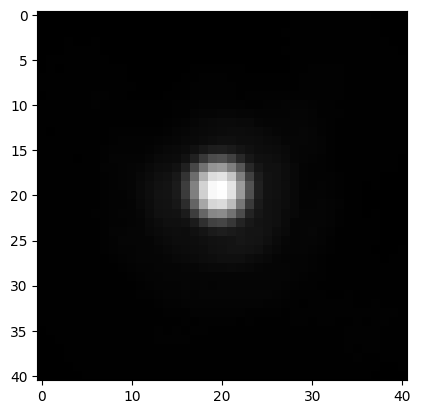

In [37]:
plt.imshow(real_PSF, cmap = "Greys_r")

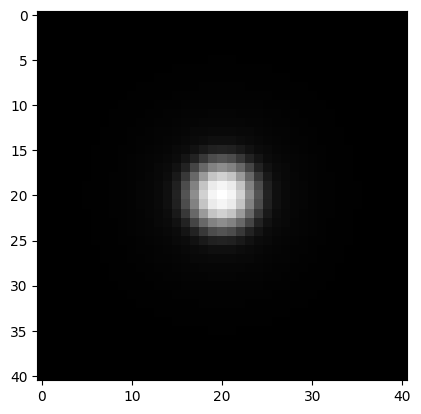

In [38]:
plt.imshow(fitted_PSF[0], cmap = "Greys_r")

In [39]:
import pickle
with open('PSF_fitted_for_single_molecule_50nm_pix_xy_only_params.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(result, file) 

tifffile.imwrite("PSF_fitted_for_single_molecule_50nm_pix_xy_only_.tif", fitted_PSF)

Full xy 

In [20]:
result.x

array([1.30657571e-02, 1.21173233e+02, 1.52966342e+00, 1.52331636e+00,
       1.55650768e+02, 1.31159562e+02, 1.88543989e+00, 1.85276293e+00,
       1.48000211e+00, 1.48843197e+00, 0.00000000e+00])

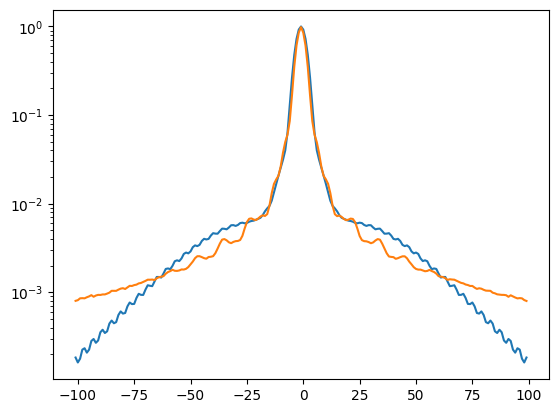

In [18]:
def PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset):
    synthetic = psfm.make_psf(
        [0],
        nx = 201,
        dxy = 0.065/1.5,
        pz = pz,
        ti0 = ti0,
        ni0 = ni0,
        ni = ni, 
        tg0 = tg0,
        ng0 = ng0,
        ng = ng,
        ns = ns,
        wvl = 0.515,
        NA = NA,
        model = "vectorial"
        ) + offset
    #synthetic -= synthetic.min()
    synthetic = synthetic / synthetic.max()
    return synthetic

real_PSF = get_real_PSF(201)
fitted_PSF = PSF_function(*result.x)

plt.plot(np.arange(-fitted_PSF.shape[1]//2,fitted_PSF.shape[1]//2),get_midline(fitted_PSF[0]), label ="fit")
plt.plot(np.arange(-real_PSF.shape[0]//2,real_PSF.shape[0]//2),get_midline_rotate_method(real_PSF), label ="fit")

plt.yscale("log")

In [56]:
real_PSF = get_real_PSF(201)

PSF_depth = 1
def PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset):
    synthetic = psfm.make_psf(
        [0],
        nx = 201,
        dxy = 0.065/1.5,
        pz = pz,
        ti0 = ti0,
        ni0 = ni0,
        ni = ni, 
        tg0 = tg0,
        ng0 = ng0,
        ng = ng,
        ns = ns,
        wvl = 0.515,
        NA = NA,
        model = "vectorial"
        ) + offset
    #synthetic -= synthetic.min()
    synthetic = synthetic / synthetic.max()
    return synthetic

def error_function(params):
    pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset = params
    #if (NA > ni) or (NA > ni0) or (pz < 0):
    #    return 1000
    synthetic = PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset)[0]
    return np.nansum((np.log(real_PSF+np.finfo(np.float16).eps) - np.log(synthetic+np.finfo(np.float16).eps)) ** 2)

In [58]:
%%time 
bounds = Bounds([0, 100, 1.49, 1.49, 100, 100, 1.5, 1.5, 1.3, 1.3, 0], [5, 200, 1.6, 1.6, 200, 200, 2, 2, 2, 1.4899, 0])
result = differential_evolution(error_function, bounds, workers = 23, disp = True, callback = check_zero_cost)

differential_evolution step 1: f(x)= 2706.393021628973
differential_evolution step 2: f(x)= 2706.393021628973
differential_evolution step 3: f(x)= 2706.393021628973
differential_evolution step 4: f(x)= 2691.14534989224
differential_evolution step 5: f(x)= 2691.14534989224
differential_evolution step 6: f(x)= 2562.4038080252894
differential_evolution step 7: f(x)= 2562.4038080252894
differential_evolution step 8: f(x)= 2562.4038080252894
differential_evolution step 9: f(x)= 2562.4038080252894
differential_evolution step 10: f(x)= 2562.4038080252894
differential_evolution step 11: f(x)= 2562.4038080252894
differential_evolution step 12: f(x)= 2562.4038080252894
differential_evolution step 13: f(x)= 2562.4038080252894
differential_evolution step 14: f(x)= 2562.4038080252894
differential_evolution step 15: f(x)= 2562.4038080252894
differential_evolution step 16: f(x)= 2562.4038080252894
differential_evolution step 17: f(x)= 2562.4038080252894
differential_evolution step 18: f(x)= 2562.4038

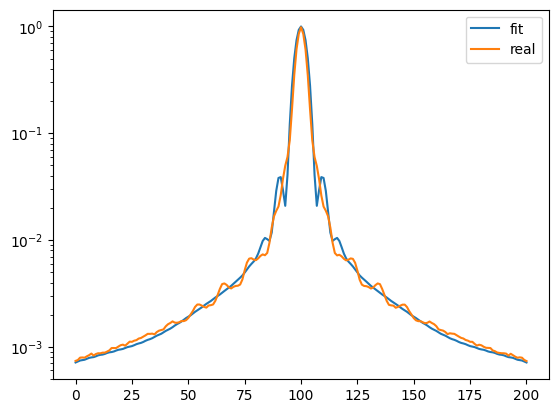

In [59]:
fitted_PSF = PSF_function(*result.x)
plt.plot(get_midline(fitted_PSF[0]), label ="fit")
plt.plot(get_midline_rotate_method(real_PSF), label = "real")
plt.yscale("log")
plt.legend()